# test_14
This test circuit has one unknown current source. 



This circuit has 

```
Net list report
number of lines in netlist: 4
number of branches: 4
number of nodes: 2
number of unknown currents: 1
number of RLC (passive components): 8
number of inductors: 1
number of independent voltage sources: 0
number of independent current sources: 2
number of op amps: 0
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 0

```


<img src="test_14.png" width="900">  

```
* test_14.asc
I1 1 0 1 
R1 1 0 0.05
L1 1 2 0.025
C1 2 0 0.25


```



This netlist is read into the Symbolic Modified Nodal Analysis Jupyter notebook and the following circuit equations were generated.  

$I_{L1} + \frac{v_{1}}{R_{1}} = - I_{1}$  
$C_{1} s v_{2} - I_{L1} = 0$  
$- I_{L1} L_{1} s + v_{1} - v_{2} = 0$  


In [69]:
import os
from sympy import *
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
init_printing()

Copy the text strings generated by the Symbolic Modified Nodal Analysis Jupyter notebook to the cell below. used in nodal analysis

In [70]:
I_L1, v1, v2, I1, R1, L1, C1, s = symbols(' I_L1  v1  v2  I1  R1  L1  C1  s ')
A = Matrix([[1/R1, 0, 1], [0, C1*s, -1], [1, -1, -L1*s]])
X = Matrix( [v1, v2, I_L1] )
Z = Matrix( [-I1, 0, 0] )

equ = Eq(A*X,Z)
equ

⎡            v₁      ⎤        
⎢     I_L1 + ──      ⎥   ⎡-I₁⎤
⎢            R₁      ⎥   ⎢   ⎥
⎢                    ⎥ = ⎢ 0 ⎥
⎢   C₁⋅s⋅v₂ - I_L1   ⎥   ⎢   ⎥
⎢                    ⎥   ⎣ 0 ⎦
⎣-I_L1⋅L₁⋅s + v₁ - v₂⎦        

## Symbolic solution

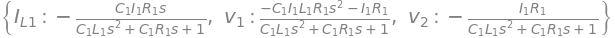

In [71]:
symbolic_solution = solve(equ,X)
symbolic_solution

## Numeric solution

In [72]:
# enter the element values, set I2=0
equ1a = equ.subs({
I1:1.0000e+00,
R1:5.0000e-02,
L1:2.5000e-02,
C1:2.5000e-01
})    

equ1a  # display the equations

⎡    I_L1 + 20.0⋅v₁     ⎤   ⎡-1.0⎤
⎢                       ⎥   ⎢    ⎥
⎢   -I_L1 + 0.25⋅s⋅v₂   ⎥ = ⎢ 0  ⎥
⎢                       ⎥   ⎢    ⎥
⎣-0.025⋅I_L1⋅s + v₁ - v₂⎦   ⎣ 0  ⎦

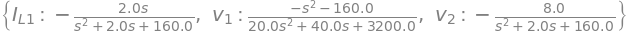

In [73]:
u1 = solve(equ1a,X)
u1

## AC analysis
Solve equations for $\omega$ equal to 1 radian per second, s = 1j.

In [74]:
1/(2*np.pi)

In [75]:
equ1a_1rad_per_s = equ1a.subs({s:1j})
equ1a_1rad_per_s  # display the equations

⎡    I_L1 + 20.0⋅v₁     ⎤   ⎡-1.0⎤
⎢                       ⎥   ⎢    ⎥
⎢   -I_L1 + 0.25⋅ⅈ⋅v₂   ⎥ = ⎢ 0  ⎥
⎢                       ⎥   ⎢    ⎥
⎣-0.025⋅ⅈ⋅I_L1 + v₁ - v₂⎦   ⎣ 0  ⎦

In [76]:
ans1 = solve(equ1a_1rad_per_s,X)
ans1

In [77]:
for name, value in ans1.items():
    print('{:5s}: mag: {:10.6f} phase: {:11.5f} deg'.format(str(name),float(abs(value)),float(arg(value)*180/np.pi)))

v1   : mag:   0.049996 phase:   179.27934 deg
v2   : mag:   0.050310 phase:   179.27934 deg
I_L1 : mag:   0.012578 phase:   -90.72066 deg


The following results were obtained from LTSpice.  
```
       --- AC Analysis ---

frequency:	0.159155	Hz
V(1):	mag:  0.0499959 phase:    179.279° 	voltage
V(2):	mag:  0.0503103 phase:    179.265° 	voltage
I(C1):	mag:  0.0125776 phase:   -90.7351° 	device_current
I(L1):	mag:  0.0125776 phase:   -90.7351° 	device_current
I(I1):	mag:          1 phase:          0° 	device_current
I(R1):	mag:   0.999918 phase:    179.279° 	device_current

```
The LTSpice results are the same.

## AC Sweep
Looking at node 5 voltage and comparing the results with those obtained from LTSpice. Thr frequency sweep is from 0.01 Hz to 1 Hz.

Load the csv file of node 5 voltage over the sweep range and plot along with the results obtained from SymPy.

In [93]:
os.chdir('/home/jeff32/Documents/Solving Electrical Engineering Problems with Python Blog/MNA Test Circuits/test_14/') # change directory to net list location

fn = 'test_14.csv' # data from LTSpice
#LTSpice_data = np.loadtxt(fn, delimiter='\t',skiprows=1)
LTSpice_data = np.genfromtxt(fn, delimiter=',',skip_header=1)

# change the working director back to the Jupyter folder
os.chdir('/home/jeff32/Documents/JupyterLab/Node Analysis/')  

In [94]:
# initaliaze some empty arrays
frequency = np.zeros(len(LTSpice_data))
V_1 = np.zeros(len(LTSpice_data)).astype(complex)
V_2 = np.zeros(len(LTSpice_data)).astype(complex)

In [95]:
# convert the csv data to complex numbers and store in the array
for i in range(len(LTSpice_data)):
    frequency[i] = LTSpice_data[i][0]
    V_1[i] = LTSpice_data[i][1] + LTSpice_data[i][2]*1j
    V_2[i] = LTSpice_data[i][3] + LTSpice_data[i][4]*1j

Load the Laplace polyinominal for node 5

In [96]:
H = u1[v2]
H

In [97]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system_v2 = (a, b) # system for circuit 1

In [98]:
#x = np.linspace(0.01*2*np.pi, 1*2*np.pi, 10000, endpoint=True)
x = np.logspace(-2, 2, 400, endpoint=False)*2*np.pi
w, mag_v2, phase_v2 = signal.bode(system_v2, w=x) # returns: rad/s, mag in dB, phase in deg

Plot the results.

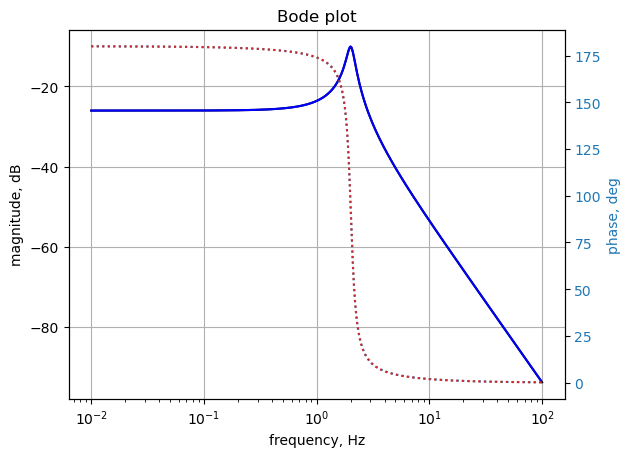

In [99]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency, 20*np.log10(np.abs(V_2)),'-k')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag_v2,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency, np.angle(V_2)*180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase_v2,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Bode plot')
plt.show()

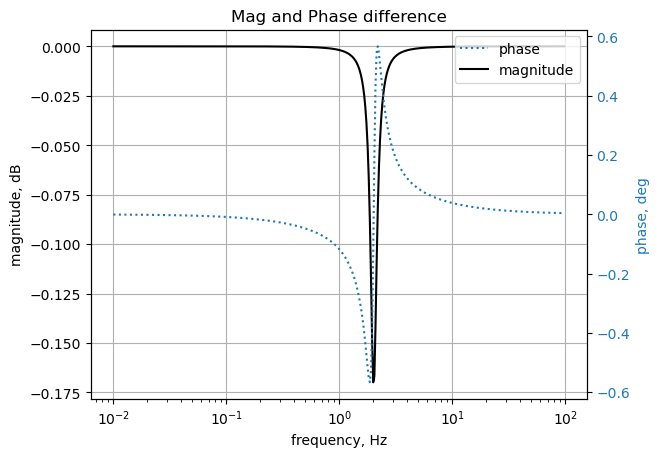

In [101]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency[0:-1], 20*np.log10(np.abs(V_2[0:-1]))-mag_v2,'-k')    # Bode magnitude plot
#plt.semilogx(w/(2*np.pi), mag_v3,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency[0:-1], np.angle(V_2[0:-1])*180/np.pi-phase_v2,':',color=color,label='phase')  # Bode phase plot
#plt.semilogx(w/(2*np.pi), phase_v3,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

ax2.plot(np.NaN, np.NaN, color='k', label='magnitude')

plt.legend()
plt.title('Mag and Phase difference')
plt.show()

The SymPy and LTSpice results overlay each other. 

In [103]:
frequency[0:-1]-w/(2*np.pi)

array([ 0.00000000e+00, -3.98986399e-17,  3.46944695e-18,  3.46944695e-17,
       -5.03069808e-17, -3.46944695e-17, -2.94902991e-17,  1.73472348e-18,
       -3.12250226e-17, -1.90819582e-17,  2.42861287e-17, -3.98986399e-17,
        2.60208521e-17, -3.12250226e-17, -5.03069808e-17, -3.98986399e-17,
        2.77555756e-17,  2.94902991e-17,  2.08166817e-17, -1.04083409e-17,
       -3.46944695e-17,  0.00000000e+00, -6.93889390e-18, -4.16333634e-17,
       -5.55111512e-17, -2.77555756e-17, -3.46944695e-17,  2.42861287e-17,
        2.77555756e-17, -5.55111512e-17,  0.00000000e+00,  6.93889390e-18,
        0.00000000e+00, -2.42861287e-17, -3.12250226e-17,  0.00000000e+00,
       -2.77555756e-17, -2.77555756e-17,  3.46944695e-18, -1.04083409e-17,
        3.46944695e-18, -4.16333634e-17, -1.73472348e-17, -5.20417043e-17,
       -5.89805982e-17, -3.12250226e-17, -5.89805982e-17, -5.20417043e-17,
       -5.89805982e-17, -3.46944695e-18, -9.02056208e-17, -2.77555756e-17,
       -1.38777878e-17, -